Epoch 1/50, Loss: 0.034783
Epoch 2/50, Loss: 0.025521
Epoch 3/50, Loss: 0.023631
Epoch 4/50, Loss: 0.023058
Epoch 5/50, Loss: 0.022697
Epoch 6/50, Loss: 0.022439
Epoch 7/50, Loss: 0.022243
Epoch 8/50, Loss: 0.022023
Epoch 9/50, Loss: 0.021847
Epoch 10/50, Loss: 0.021708
Epoch 11/50, Loss: 0.021518
Epoch 12/50, Loss: 0.021344
Epoch 13/50, Loss: 0.021126
Epoch 14/50, Loss: 0.020989
Epoch 15/50, Loss: 0.020548
Epoch 16/50, Loss: 0.020487
Epoch 17/50, Loss: 0.020629
Epoch 18/50, Loss: 0.019802
Epoch 19/50, Loss: 0.019666
Epoch 20/50, Loss: 0.019449
Epoch 21/50, Loss: 0.018741
Epoch 22/50, Loss: 0.019481
Epoch 23/50, Loss: 0.018515
Epoch 24/50, Loss: 0.017604
Epoch 25/50, Loss: 0.018126
Epoch 26/50, Loss: 0.017381
Epoch 27/50, Loss: 0.017329
Epoch 28/50, Loss: 0.016421
Epoch 29/50, Loss: 0.017930
Epoch 30/50, Loss: 0.019151
Epoch 31/50, Loss: 0.018571
Epoch 32/50, Loss: 0.020138
Epoch 33/50, Loss: 0.017294
Epoch 34/50, Loss: 0.015891
Epoch 35/50, Loss: 0.015254
Epoch 36/50, Loss: 0.015402
E

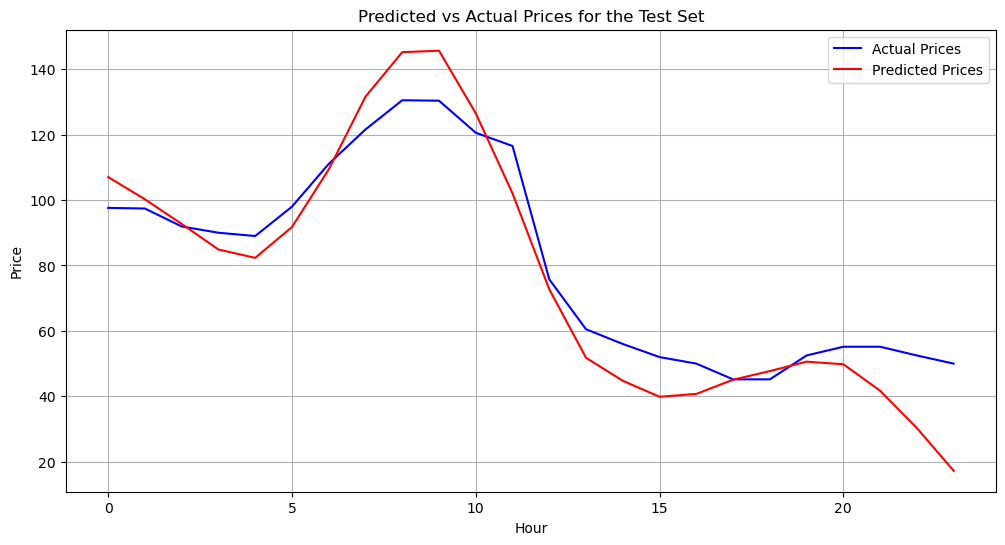

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# File paths
file_path = '../TrainingData/trainingdata_23_24.csv'

# Define input and output sequence lengths
sequence_length = 336  # Use 2 weeks of history
output_sequence_length = 24  # Predict the next 24 hours
batch_size = 32

# Load data in chunks and split into training and test datasets
train_data = []
test_data = []
test_split_ratio = 0.1  # Use the last 10% for testing

# Initialize separate scalers for Price1 and Price2
scaler_price1 = MinMaxScaler(feature_range=(0, 1))
scaler_price2 = MinMaxScaler(feature_range=(0, 1))
scaler_features = MinMaxScaler(feature_range=(0, 1))  # For other features

# Read the file in chunks
chunksize = 10_000
reader = pd.read_csv(file_path, chunksize=chunksize)

for chunk in reader:
    # Prepare input features and target prices
    price1 = chunk[['Price1']].values
    price2 = chunk[['Price2']].values
    features = chunk[['Hour_Sin', 'Hour_Cos', 'Day_Sin', 'Day_Cos', 'Month_Sin', 'Month_Cos']].values

    # Fit scalers on the entire dataset
    scaler_price1.partial_fit(price1)
    scaler_price2.partial_fit(price2)
    scaler_features.partial_fit(features)

# Second pass to transform data
reader = pd.read_csv(file_path, chunksize=chunksize)

for chunk in reader:
    # Prepare input features and target prices
    price1_scaled = scaler_price1.transform(chunk[['Price1']].values)
    price2_scaled = scaler_price2.transform(chunk[['Price2']].values)
    features_scaled = scaler_features.transform(chunk[['Hour_Sin', 'Hour_Cos', 'Day_Sin', 'Day_Cos', 'Month_Sin', 'Month_Cos']].values)

    # Combine scaled features
    combined_features = np.hstack([price1_scaled, price2_scaled, features_scaled])

    if len(combined_features) < sequence_length + output_sequence_length:
        continue  # Skip chunks that are too small for the sequence lengths

    X, y = [], []
    for i in range(len(combined_features) - sequence_length - output_sequence_length):
        X.append(combined_features[i:i + sequence_length])  # Input sequence
        y.append(price1_scaled[i + sequence_length:i + sequence_length + output_sequence_length, 0])  # Target sequence
    
    if len(test_data) == 0:  # Reserve the last portion of the data for testing
        test_start_idx = int(len(X) * (1 - test_split_ratio))
        train_data.append((X[:test_start_idx], y[:test_start_idx]))
        test_data = (X[test_start_idx:], y[test_start_idx:])
    else:
        train_data.append((X, y))

# Combine training data
X_train = np.concatenate([data[0] for data in train_data], axis=0)
y_train = np.concatenate([data[1] for data in train_data], axis=0)

# Prepare test data
X_test, y_test = np.array(test_data[0]), np.array(test_data[1])

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define LSTM model (as in your code)
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[:, -1, :])
        return output

# Model parameters
input_size = X_train.shape[2]
hidden_size = 50
output_size = output_sequence_length

model = LSTMModel(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_loader):.6f}")

# Model evaluation and visualization
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test).numpy()

# Rescale predictions and actual values for Price1
y_test_pred_rescaled = scaler_price1.inverse_transform(y_test_pred)
y_test_actual_rescaled = scaler_price1.inverse_transform(y_test.numpy())

# Plotting predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test_actual_rescaled[0])), y_test_actual_rescaled[0], label="Actual Prices", color="blue")
plt.plot(range(len(y_test_pred_rescaled[0])), y_test_pred_rescaled[0], label="Predicted Prices", color="red")
plt.title("Predicted vs Actual Prices for the Test Set")
plt.xlabel("Hour")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


### Visualization of Predictions ###
Best Performance (Index: 275) - RMSE: 5.99, MAPE: 4.90%, R-squared: 0.90


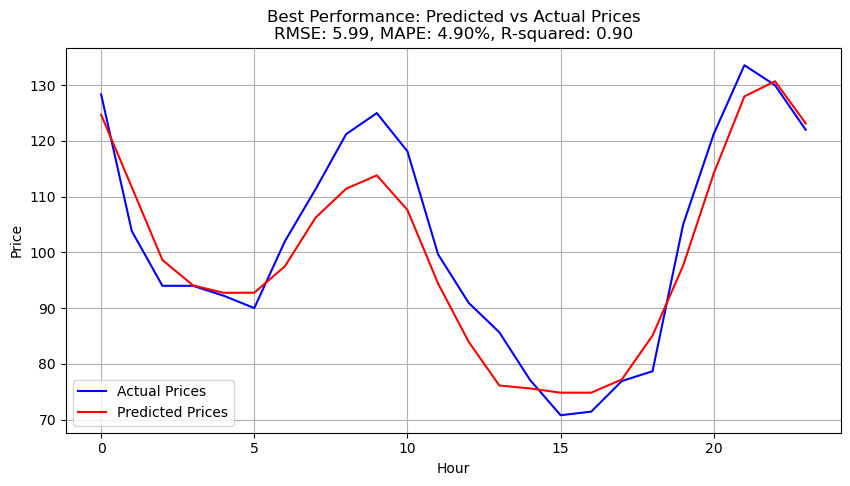

Worst Performance (Index: 372) - RMSE: 110.97, MAPE: 74.78%, R-squared: -62.44


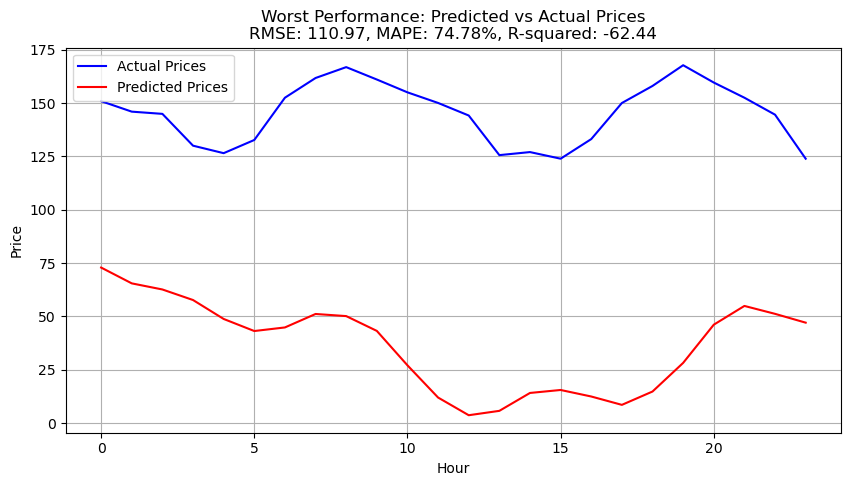

Median Performance (Index: 701) - RMSE: 26.29, MAPE: 20.15%, R-squared: -0.01


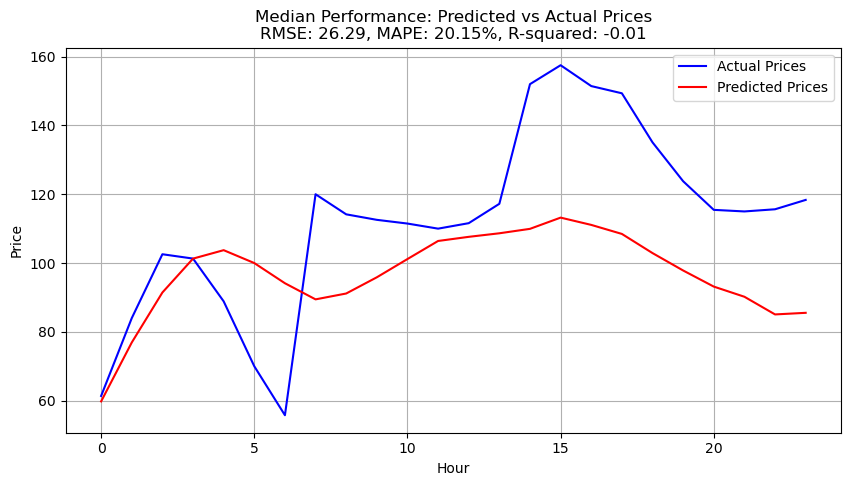

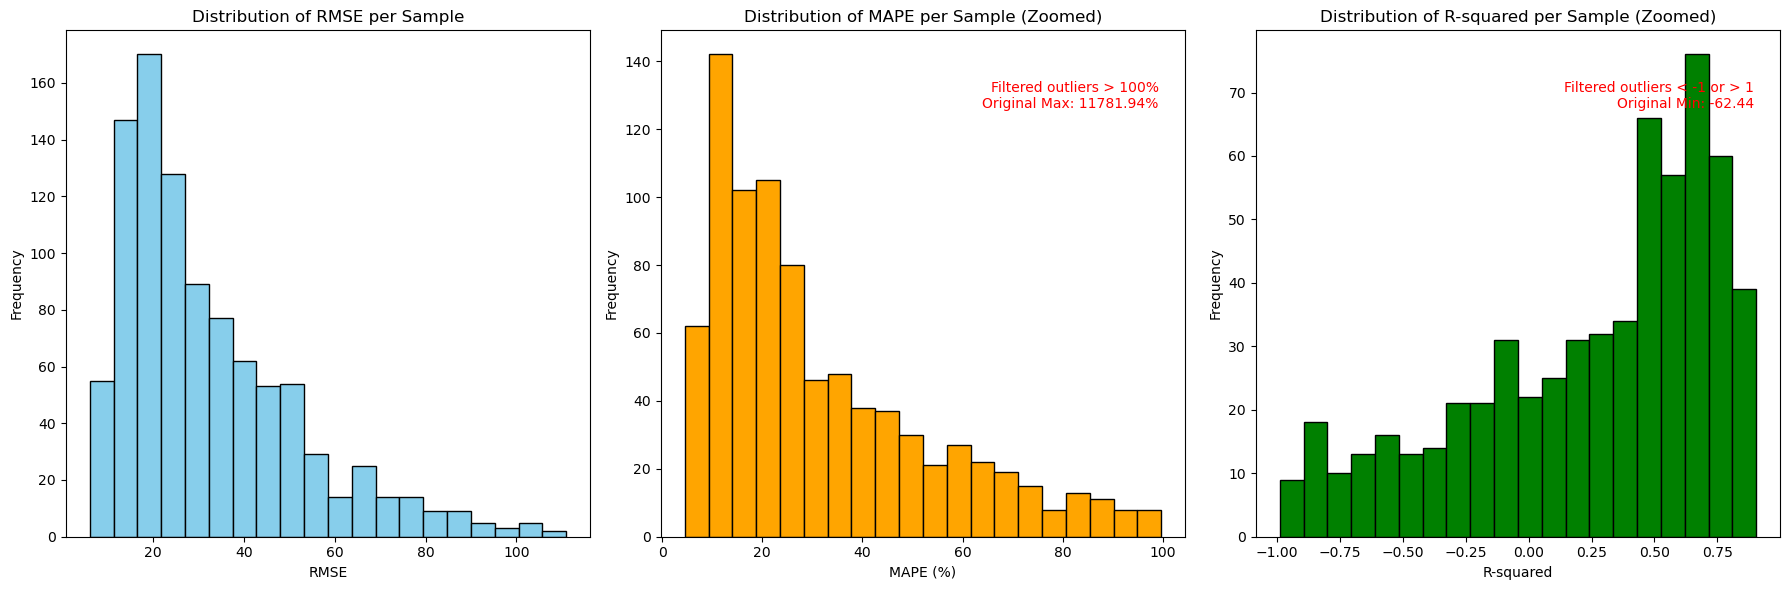


### Per-Sample Metrics Summary (Original Data) ###
Average RMSE: 32.18
Average MAPE: 243.71%
Average R-squared: -1.61
Median RMSE: 26.27
Median MAPE: 27.63%
Median R-squared: -0.17
Maximum RMSE: 110.97
Minimum RMSE: 5.99
Maximum MAPE: 11781.94%
Minimum MAPE: 4.50%
Maximum R-squared: 0.90
Minimum R-squared: -62.44

### Filtered Metrics Summary (Excluding Extreme Outliers) ###
Filtered MAPE (Max): 99.65%
Filtered R-squared (Min): -0.99


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Predict on test data using PyTorch
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test).numpy()  # Get predictions as numpy array

# Inverse transform predictions and actual values for Price1
y_test_pred = scaler_price1.inverse_transform(y_test_pred)
y_test_actual = scaler_price1.inverse_transform(y_test.numpy())

# Calculate RMSE, MAPE, and R-squared for each sample
rmse_per_sample = []
mape_per_sample = []
r2_per_sample = []

for actual, predicted in zip(y_test_actual, y_test_pred):
    rmse_per_sample.append(np.sqrt(mean_squared_error(actual, predicted)))
    mape_per_sample.append(np.mean(np.abs((actual - predicted) / actual)) * 100)
    r2_per_sample.append(r2_score(actual, predicted))

# Find indices for best, median, and worst performance based on RMSE
best_index = np.argmin(rmse_per_sample)
worst_index = np.argmax(rmse_per_sample)
median_index = np.argsort(rmse_per_sample)[len(rmse_per_sample) // 2]

# Function to visualize a single prediction vs. actual with metrics
def plot_prediction_with_metrics(index, title):
    actual = y_test_actual[index]
    predicted = y_test_pred[index]
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    r2 = r2_score(actual, predicted)
    plt.figure(figsize=(10, 5))
    plt.plot(actual, label="Actual Prices", color="blue")
    plt.plot(predicted, label="Predicted Prices", color="red")
    plt.title(f"{title}\nRMSE: {rmse:.2f}, MAPE: {mape:.2f}%, R-squared: {r2:.2f}")
    plt.xlabel("Hour")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize worst, best, and median performances
print("### Visualization of Predictions ###")
print(f"Best Performance (Index: {best_index}) - RMSE: {rmse_per_sample[best_index]:.2f}, "
      f"MAPE: {mape_per_sample[best_index]:.2f}%, R-squared: {r2_per_sample[best_index]:.2f}")
plot_prediction_with_metrics(best_index, "Best Performance: Predicted vs Actual Prices")

print(f"Worst Performance (Index: {worst_index}) - RMSE: {rmse_per_sample[worst_index]:.2f}, "
      f"MAPE: {mape_per_sample[worst_index]:.2f}%, R-squared: {r2_per_sample[worst_index]:.2f}")
plot_prediction_with_metrics(worst_index, "Worst Performance: Predicted vs Actual Prices")

print(f"Median Performance (Index: {median_index}) - RMSE: {rmse_per_sample[median_index]:.2f}, "
      f"MAPE: {mape_per_sample[median_index]:.2f}%, R-squared: {r2_per_sample[median_index]:.2f}")
plot_prediction_with_metrics(median_index, "Median Performance: Predicted vs Actual Prices")

# Plot histograms of metrics distributions with filtered ranges
plt.figure(figsize=(18, 6))

# RMSE distribution
plt.subplot(1, 3, 1)
plt.hist(rmse_per_sample, bins=20, color="skyblue", edgecolor="black")
plt.title("Distribution of RMSE per Sample")
plt.xlabel("RMSE")
plt.ylabel("Frequency")

# MAPE distribution (filter extreme outliers)
filtered_mape = [m for m in mape_per_sample if m < 100]  # Exclude outliers beyond 100%
plt.subplot(1, 3, 2)
plt.hist(filtered_mape, bins=20, color="orange", edgecolor="black")
plt.title("Distribution of MAPE per Sample (Zoomed)")
plt.xlabel("MAPE (%)")
plt.ylabel("Frequency")
plt.text(0.95, 0.9, f"Filtered outliers > 100%\nOriginal Max: {np.max(mape_per_sample):.2f}%",
         transform=plt.gca().transAxes, fontsize=10, ha='right', va='top', color='red')

# R-squared distribution (focus on meaningful range)
filtered_r2 = [r for r in r2_per_sample if -1 <= r <= 1]  # Exclude extreme values
plt.subplot(1, 3, 3)
plt.hist(filtered_r2, bins=20, color="green", edgecolor="black")
plt.title("Distribution of R-squared per Sample (Zoomed)")
plt.xlabel("R-squared")
plt.ylabel("Frequency")
plt.text(0.95, 0.9, f"Filtered outliers < -1 or > 1\nOriginal Min: {np.min(r2_per_sample):.2f}",
         transform=plt.gca().transAxes, fontsize=10, ha='right', va='top', color='red')

plt.tight_layout()
plt.show()

# Updated Summary Statistics (original data)
print("\n### Per-Sample Metrics Summary (Original Data) ###")
print(f"Average RMSE: {np.mean(rmse_per_sample):.2f}")
print(f"Average MAPE: {np.mean(mape_per_sample):.2f}%")
print(f"Average R-squared: {np.mean(r2_per_sample):.2f}")
print(f"Median RMSE: {np.median(rmse_per_sample):.2f}")
print(f"Median MAPE: {np.median(mape_per_sample):.2f}%")
print(f"Median R-squared: {np.median(r2_per_sample):.2f}")
print(f"Maximum RMSE: {np.max(rmse_per_sample):.2f}")
print(f"Minimum RMSE: {np.min(rmse_per_sample):.2f}")
print(f"Maximum MAPE: {np.max(mape_per_sample):.2f}%")
print(f"Minimum MAPE: {np.min(mape_per_sample):.2f}%")
print(f"Maximum R-squared: {np.max(r2_per_sample):.2f}")
print(f"Minimum R-squared: {np.min(r2_per_sample):.2f}")

# Additional Summary (filtered data)
print("\n### Filtered Metrics Summary (Excluding Extreme Outliers) ###")
print(f"Filtered MAPE (Max): {np.max(filtered_mape):.2f}%")
print(f"Filtered R-squared (Min): {np.min(filtered_r2):.2f}")




In [ ]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('../TrainingData/trainingdata23.csv')

# Define input and output sequence lengths
sequence_length = 336  # Use 2 weeks of history (24 * 14 = 336 hours)
output_sequence_length = 24  # Predict the next 24 hours

# Extract features and target column
features = data[['Price1', 'Price2', 'Hour_Sin', 'Hour_Cos', 'Day_Sin', 'Day_Cos', 'Month_Sin', 'Month_Cos']].values

# Scale features
scaler_X = MinMaxScaler(feature_range=(0, 1))
features_scaled = scaler_X.fit_transform(features)

# Prepare input-output sequences
X, y = [], []
for i in range(len(features) - sequence_length - output_sequence_length):
    X.append(features_scaled[i:i + sequence_length])  # Input: last 2 weeks
    y.append(features_scaled[i + sequence_length:i + sequence_length + output_sequence_length, 0])  # Output: next 24 hours of `Price1`

X = np.array(X)
y = np.array(y)

# Split the last 24 hours as the test set
X_train, y_train = X[:-5], y[:-5]  # Use all but the last 24 hours for training
X_test, y_test = X[-5:], y[-5:]    # Use only the last 24 hours for testing

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Define PyTorch Dataset and DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Use the last LSTM output
        return out

# Model parameters
input_dim = X_train.shape[2]
hidden_dim = 20
output_dim = output_sequence_length
num_layers = 2

model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training Loop
epochs = 40
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")


Epoch 1/40, Loss: 14.6413
Epoch 2/40, Loss: 7.9406
Epoch 3/40, Loss: 6.9198
Epoch 4/40, Loss: 6.3637
Epoch 5/40, Loss: 5.7745
Epoch 6/40, Loss: 5.6132
Epoch 7/40, Loss: 5.4762
Epoch 8/40, Loss: 5.4168
Epoch 9/40, Loss: 5.3548
Epoch 10/40, Loss: 5.3325
Epoch 11/40, Loss: 5.3111
Epoch 12/40, Loss: 5.2581
Epoch 13/40, Loss: 5.2270
Epoch 14/40, Loss: 5.2029
Epoch 15/40, Loss: 5.1725
Epoch 16/40, Loss: 5.1506
Epoch 17/40, Loss: 5.1428
Epoch 18/40, Loss: 5.1116
Epoch 19/40, Loss: 5.0842
Epoch 20/40, Loss: 5.0559
Epoch 21/40, Loss: 5.0604
Epoch 22/40, Loss: 5.0004
Epoch 23/40, Loss: 4.9917
Epoch 24/40, Loss: 4.9720
Epoch 25/40, Loss: 4.8957
Epoch 26/40, Loss: 4.8598
Epoch 27/40, Loss: 4.7926
Epoch 28/40, Loss: 4.7194
Epoch 29/40, Loss: 4.6962
Epoch 30/40, Loss: 4.6319
Epoch 31/40, Loss: 4.5495
Epoch 32/40, Loss: 4.5248
Epoch 33/40, Loss: 4.4231
Epoch 34/40, Loss: 4.3338
Epoch 35/40, Loss: 4.2807
Epoch 36/40, Loss: 4.2119
Epoch 37/40, Loss: 4.1821
Epoch 38/40, Loss: 4.1778
Epoch 39/40, Loss: 4

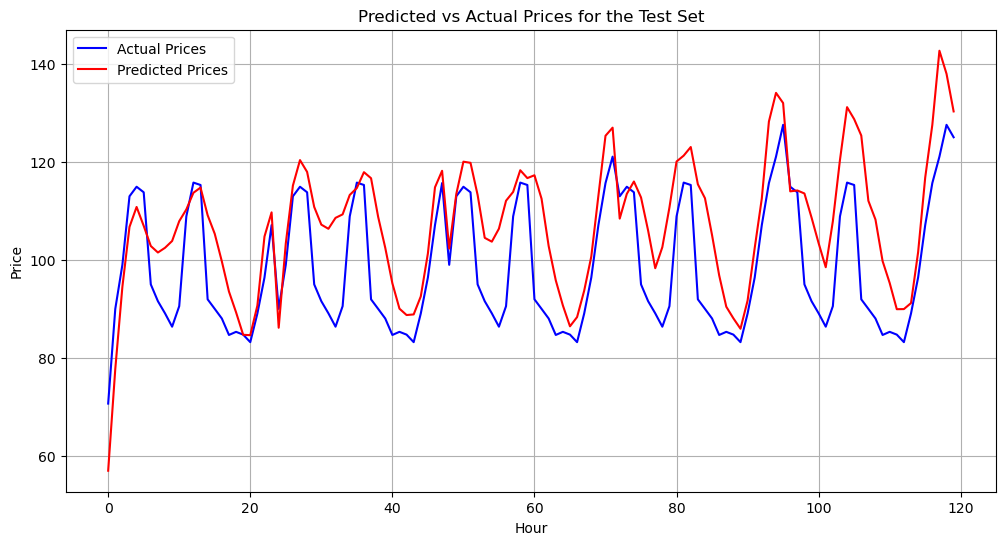

In [29]:
# Evaluate on Test Set
model.eval()
with torch.no_grad():
    test_predictions = model(X_test).numpy()  # Shape: (batch_size, output_sequence_length)
    test_actual = y_test.numpy()  # Shape: (batch_size, output_sequence_length)

# Ensure both arrays are 2D and have matching shapes
test_predictions = test_predictions.reshape(-1, test_predictions.shape[-1])  # (num_samples, output_sequence_length)
test_actual = test_actual.reshape(-1, test_actual.shape[-1])  # (num_samples, output_sequence_length)

# Use scaler_y to inverse transform predictions and actuals
test_predictions_rescaled = scaler_y.inverse_transform(test_predictions)
test_actual_rescaled = scaler_y.inverse_transform(test_actual)

# Flatten both arrays for plotting
test_predictions_flat = test_predictions_rescaled.flatten()  # Shape: (num_samples * output_sequence_length,)
test_actual_flat = test_actual_rescaled.flatten()  # Shape: (num_samples * output_sequence_length,)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(range(len(test_actual_flat)), test_actual_flat, label="Actual Prices", color="blue")
plt.plot(range(len(test_predictions_flat)), test_predictions_flat, label="Predicted Prices", color="red")
plt.title("Predicted vs Actual Prices for the Test Set")
plt.xlabel("Hour")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


In [30]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(test_actual_flat, test_predictions_flat))
print(f"RMSE: {rmse:.2f}")
mape = np.mean(np.abs((test_actual_flat - test_predictions_flat) / test_actual_flat)) * 100
print(f"MAPE: {mape:.2f}%")
from sklearn.metrics import r2_score

r2 = r2_score(test_actual_flat, test_predictions_flat)
print(f"R-squared: {r2:.2f}")



RMSE: 12.09
MAPE: 10.43%
R-squared: 0.15


Working Directory: /home/teitur/DTU/electricproject/deeplearning/LSTM
Resuming training from checkpoint...
Checkpoint loaded. Resuming from epoch 100.


/tmp/ipykernel_3549/696148734.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Epoch 101/200, Train Loss: 0.001387, Val Loss: 0.001400
New best model saved with validation loss: 0.001400
Epoch 102/200, Train Loss: 0.001437, Val Loss: 0.001402
Epoch 103/200, Train Loss: 0.002677, Val Loss: 0.001498
Epoch 104/200, Train Loss: 0.001385, Val Loss: 0.001297
New best model saved with validation loss: 0.001297
Epoch 105/200, Train Loss: 0.001331, Val Loss: 0.001354
Epoch 106/200, Train Loss: 0.001639, Val Loss: 0.001792
Epoch 107/200, Train Loss: 0.001365, Val Loss: 0.001301
Epoch 108/200, Train Loss: 0.001343, Val Loss: 0.001295
New best model saved with validation loss: 0.001295
Epoch 109/200, Train Loss: 0.001336, Val Loss: 0.001438
Epoch 110/200, Train Loss: 0.001780, Val Loss: 0.001301
Epoch 111/200, Train Loss: 0.001268, Val Loss: 0.001268
New best model saved with validation loss: 0.001268
Epoch 112/200, Train Loss: 0.001292, Val Loss: 0.001278
Epoch 113/200, Train Loss: 0.001441, Val Loss: 0.001226
New best model saved with validation loss: 0.001226
Epoch 114/20

/tmp/ipykernel_3549/696148734.py:194: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path)['model_state_dict'])


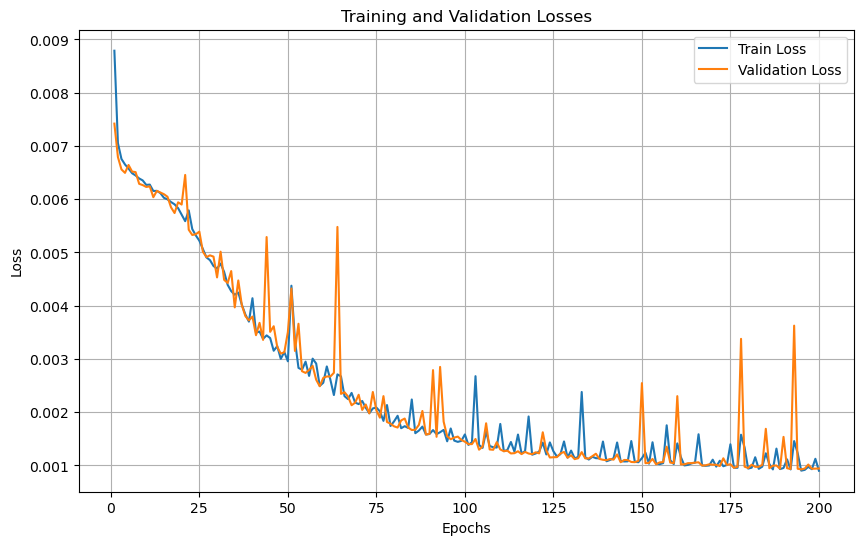

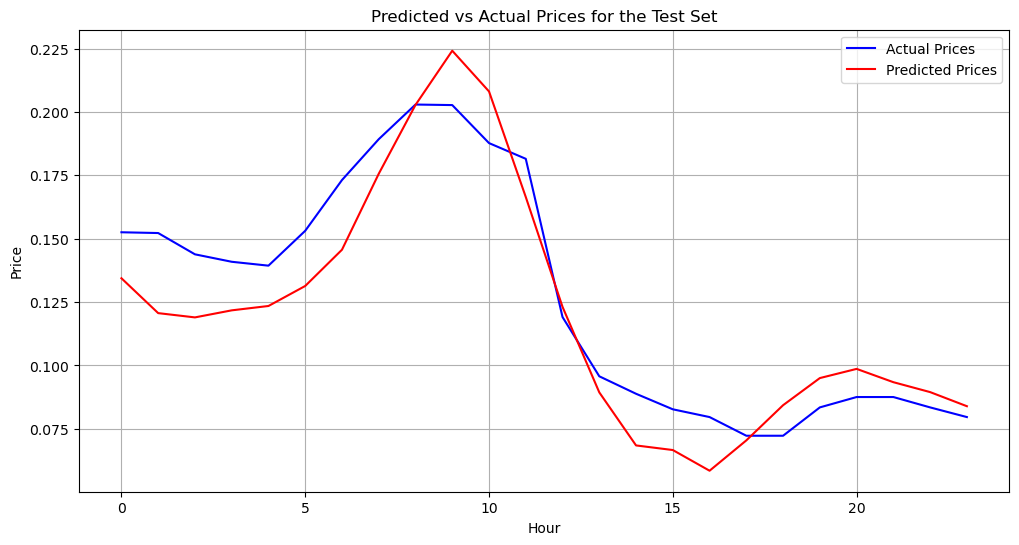

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

print("Working Directory:", os.getcwd())

# File paths
file_path = '../TrainingData/trainingdata_20_24.csv'

# Define input and output sequence lengths
sequence_length = 336  # Use 2 weeks of history
output_sequence_length = 24  # Predict the next 24 hours
batch_size = 32

# Load data in chunks and split into training and test datasets
train_data = []
test_data = []
test_split_ratio = 0.1  # Use the last 10% for testing

# Initialize scalers
scaler_price1 = MinMaxScaler(feature_range=(0, 1))
scaler_price2 = MinMaxScaler(feature_range=(0, 1))
scaler_features = MinMaxScaler(feature_range=(0, 1))

# First pass: Fit the scalers
chunksize = 10_000
reader = pd.read_csv(file_path, chunksize=chunksize)

for chunk in reader:
    price1 = chunk[['Price1']].values
    price2 = chunk[['Price2']].values
    features = chunk[['Hour_Sin', 'Hour_Cos', 'Day_Sin', 'Day_Cos', 'Month_Sin', 'Month_Cos']].values
    scaler_price1.partial_fit(price1)
    scaler_price2.partial_fit(price2)
    scaler_features.partial_fit(features)

# Second pass: Transform the data
reader = pd.read_csv(file_path, chunksize=chunksize)

for chunk in reader:
    price1_scaled = scaler_price1.transform(chunk[['Price1']].values)
    price2_scaled = scaler_price2.transform(chunk[['Price2']].values)
    features_scaled = scaler_features.transform(chunk[['Hour_Sin', 'Hour_Cos', 'Day_Sin', 'Day_Cos', 'Month_Sin', 'Month_Cos']].values)

    # Combine scaled features
    combined_features = np.hstack([price1_scaled, price2_scaled, features_scaled])

    if len(combined_features) < sequence_length + output_sequence_length:
        continue  # Skip chunks that are too small for the sequence lengths

    X, y = [], []
    for i in range(len(combined_features) - sequence_length - output_sequence_length):
        X.append(combined_features[i:i + sequence_length])  # Input sequence
        y.append(price1_scaled[i + sequence_length:i + sequence_length + output_sequence_length, 0])  # Target sequence

    if len(test_data) == 0:  # Reserve the last portion of the data for testing
        test_start_idx = int(len(X) * (1 - test_split_ratio))
        train_data.append((X[:test_start_idx], y[:test_start_idx]))
        test_data = (X[test_start_idx:], y[test_start_idx:])
    else:
        train_data.append((X, y))

# Combine training data
X_train = np.concatenate([data[0] for data in train_data], axis=0)
y_train = np.concatenate([data[1] for data in train_data], axis=0)

# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)

# Prepare test data
X_test, y_test = np.array(test_data[0]), np.array(test_data[1])


# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[:, -1, :])
        return output

# Model parameters
input_size = X_train.shape[2]
hidden_size = 50
output_size = output_sequence_length

model = LSTMModel(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Checkpoint settings
patience = 20  # Early stopping patience
best_val_loss = float('inf')
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "model_checkpoint.pth")

# Load checkpoint if available
start_epoch = 0
train_losses = []
val_losses = []
if os.path.exists(checkpoint_path):
    print("Resuming training from checkpoint...")
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    best_val_loss = checkpoint['best_val_loss']
    print(f"Checkpoint loaded. Resuming from epoch {start_epoch}.")

# Training loop with early stopping
epochs = 100
no_improvement_epochs = 0

for epoch in range(start_epoch, start_epoch + epochs):
    model.train()
    epoch_train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    # Record training loss
    train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(train_loss)

    # Evaluate on validation set
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            epoch_val_loss += loss.item()

    val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch + 1}/{start_epoch + epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            'best_val_loss': best_val_loss
        }, checkpoint_path)
        print(f"New best model saved with validation loss: {val_loss:.6f}")
        no_improvement_epochs = 0  # Reset patience counter
    else:
        no_improvement_epochs += 1

    # Early stopping
    if no_improvement_epochs >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Load the best model for evaluation
model.load_state_dict(torch.load(checkpoint_path)['model_state_dict'])
print("Best model loaded for evaluation.")

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Losses")
plt.legend()
plt.grid()
plt.show()

# Evaluate on test set
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test).numpy()

# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test[0])), y_test[0], label="Actual Prices", color="blue")
plt.plot(range(len(y_test_pred[0])), y_test_pred[0], label="Predicted Prices", color="red")
plt.title("Predicted vs Actual Prices for the Test Set")
plt.xlabel("Hour")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()


### Visualization of Predictions ###
Best Performance (Index: 1) - RMSE: 8.29, MAPE: 8.96%, R-squared: 0.92


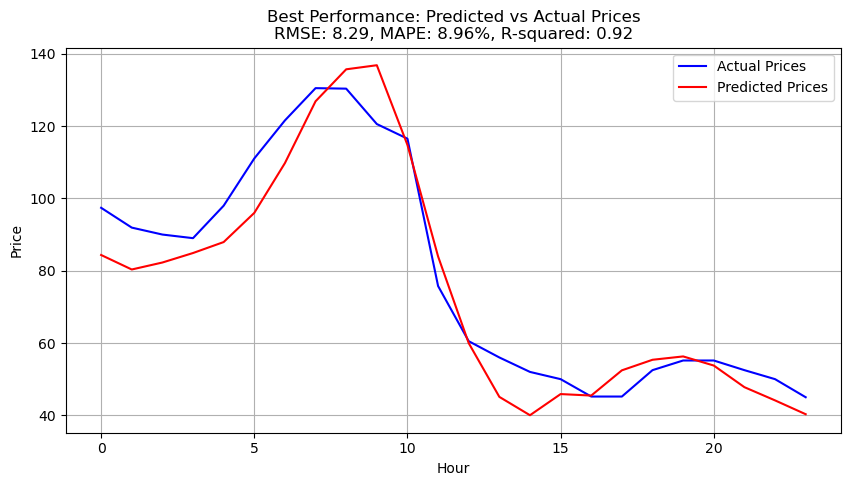

Worst Performance (Index: 660) - RMSE: 120.31, MAPE: 17123.05%, R-squared: -27.33


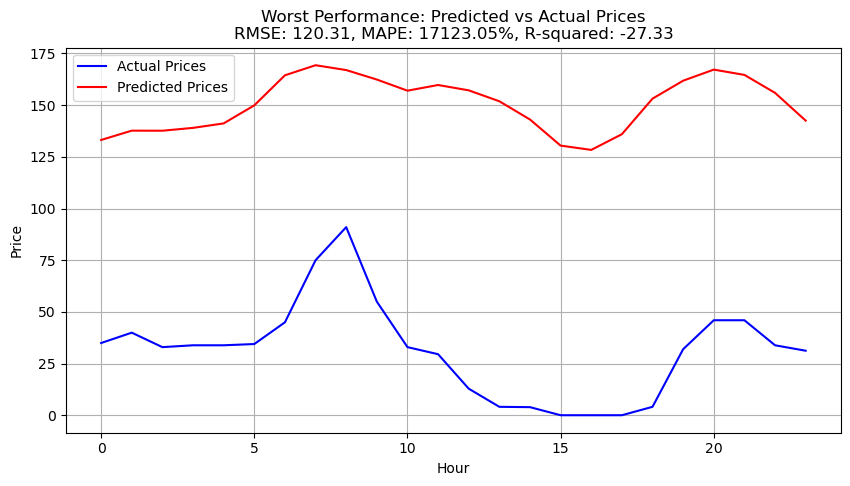

Median Performance (Index: 769) - RMSE: 38.45, MAPE: 33.28%, R-squared: -1.89


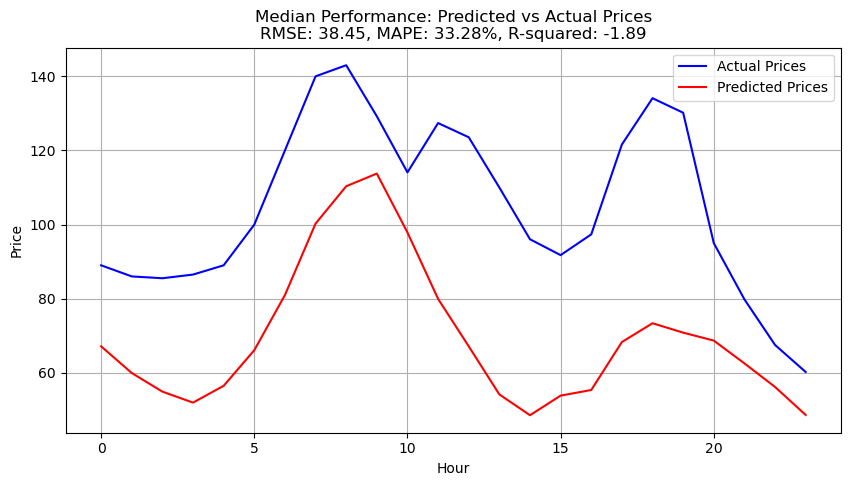

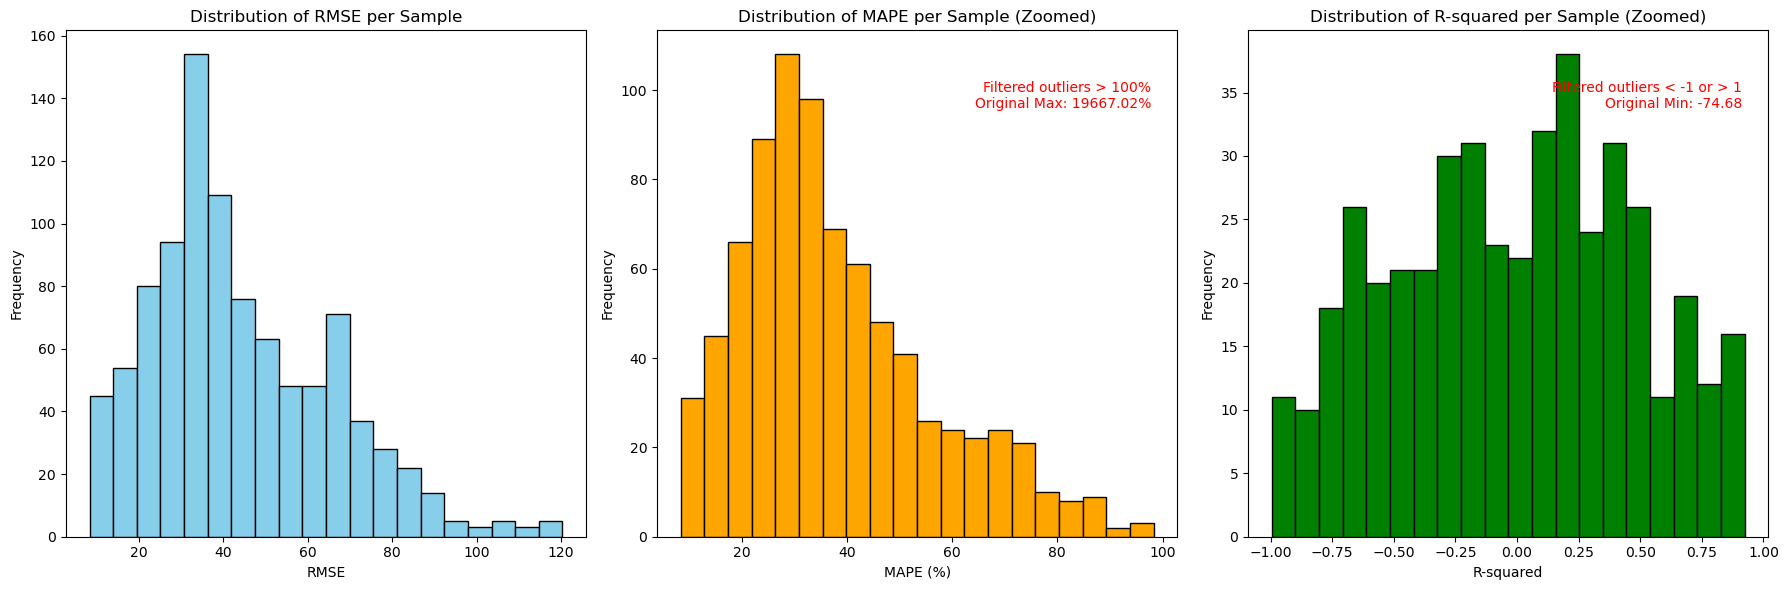


### Per-Sample Metrics Summary (Inverse Transformed Data) ###
Average RMSE: 44.02
Average MAPE: 484.96%
Average R-squared: -4.12
Median RMSE: 38.39
Median MAPE: 38.47%
Median R-squared: -1.46
Maximum RMSE: 120.31
Minimum RMSE: 8.29
Maximum MAPE: 19667.02%
Minimum MAPE: 8.44%
Maximum R-squared: 0.92
Minimum R-squared: -74.68

### Filtered Metrics Summary (Excluding Extreme Outliers) ###
Filtered MAPE (Max): 98.30%
Filtered R-squared (Min): -1.00


In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import torch

# Predict on test data using PyTorch
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test).numpy()  # Get predictions as numpy array

# Inverse transform predictions and actual values for Price1
y_test_pred = scaler_price1.inverse_transform(y_test_pred)  # Inverse transform for predictions
y_test_actual = scaler_price1.inverse_transform(y_test.numpy())  # Inverse transform for actual values

# Calculate RMSE, MAPE, and R-squared for each sample
rmse_per_sample = []
mape_per_sample = []
r2_per_sample = []

for actual, predicted in zip(y_test_actual, y_test_pred):
    rmse_per_sample.append(np.sqrt(mean_squared_error(actual, predicted)))
    mape_per_sample.append(np.mean(np.abs((actual - predicted) / actual)) * 100)
    r2_per_sample.append(r2_score(actual, predicted))

# Find indices for best, median, and worst performance based on RMSE
best_index = np.argmin(rmse_per_sample)
worst_index = np.argmax(rmse_per_sample)
median_index = np.argsort(rmse_per_sample)[len(rmse_per_sample) // 2]

# Function to visualize a single prediction vs. actual with metrics
def plot_prediction_with_metrics(index, title):
    actual = y_test_actual[index]
    predicted = y_test_pred[index]
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    r2 = r2_score(actual, predicted)
    plt.figure(figsize=(10, 5))
    plt.plot(actual, label="Actual Prices", color="blue")
    plt.plot(predicted, label="Predicted Prices", color="red")
    plt.title(f"{title}\nRMSE: {rmse:.2f}, MAPE: {mape:.2f}%, R-squared: {r2:.2f}")
    plt.xlabel("Hour")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to visualize a single prediction vs. actual with metrics with histogram
def plot_prediction_with_metrics_block(index, title):
    actual = y_test_actual[index]
    predicted = y_test_pred[index]
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    r2 = r2_score(actual, predicted)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(actual, label="Actual Prices", color="blue")
    plt.plot(predicted, label="Predicted Prices", color="red")
    plt.title(f"{title}\nRMSE: {rmse:.2f}, MAPE: {mape:.2f}%, R-squared: {r2:.2f}")
    plt.xlabel("Hour")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)

    # Histogram of actual and predicted prices plotted against hours the same way as the line plot but I want the columns to be side by side, so you can compare each hour
    plt.subplot(1, 2, 2)
    plt.bar(np.arange(len(actual)), actual, width=0.4, label="Actual Prices", color="blue", alpha=0.7)
    plt.bar(np.arange(len(predicted)) + 0.4, predicted, width=0.4, label="Predicted Prices", color="red", alpha=0.7)
    plt.title("Actual and Predicted Prices per Hour")
    plt.xlabel("Hour")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()



# Visualize worst, best, and median performances
print("### Visualization of Predictions ###")
print(f"Best Performance (Index: {best_index}) - RMSE: {rmse_per_sample[best_index]:.2f}, "
      f"MAPE: {mape_per_sample[best_index]:.2f}%, R-squared: {r2_per_sample[best_index]:.2f}")
plot_prediction_with_metrics(best_index, "Best Performance: Predicted vs Actual Prices")

print(f"Worst Performance (Index: {worst_index}) - RMSE: {rmse_per_sample[worst_index]:.2f}, "
      f"MAPE: {mape_per_sample[worst_index]:.2f}%, R-squared: {r2_per_sample[worst_index]:.2f}")
plot_prediction_with_metrics(worst_index, "Worst Performance: Predicted vs Actual Prices")

print(f"Median Performance (Index: {median_index}) - RMSE: {rmse_per_sample[median_index]:.2f}, "
      f"MAPE: {mape_per_sample[median_index]:.2f}%, R-squared: {r2_per_sample[median_index]:.2f}")
plot_prediction_with_metrics(median_index, "Median Performance: Predicted vs Actual Prices")

# Plot histograms of metrics distributions with filtered ranges
plt.figure(figsize=(18, 6))

# RMSE distribution
plt.subplot(1, 3, 1)
plt.hist(rmse_per_sample, bins=20, color="skyblue", edgecolor="black")
plt.title("Distribution of RMSE per Sample")
plt.xlabel("RMSE")
plt.ylabel("Frequency")

# MAPE distribution (filter extreme outliers)
filtered_mape = [m for m in mape_per_sample if m < 100]  # Exclude outliers beyond 100%
plt.subplot(1, 3, 2)
plt.hist(filtered_mape, bins=20, color="orange", edgecolor="black")
plt.title("Distribution of MAPE per Sample (Zoomed)")
plt.xlabel("MAPE (%)")
plt.ylabel("Frequency")
plt.text(0.95, 0.9, f"Filtered outliers > 100%\nOriginal Max: {np.max(mape_per_sample):.2f}%",
         transform=plt.gca().transAxes, fontsize=10, ha='right', va='top', color='red')

# R-squared distribution (focus on meaningful range)
filtered_r2 = [r for r in r2_per_sample if -1 <= r <= 1]  # Exclude extreme values
plt.subplot(1, 3, 3)
plt.hist(filtered_r2, bins=20, color="green", edgecolor="black")
plt.title("Distribution of R-squared per Sample (Zoomed)")
plt.xlabel("R-squared")
plt.ylabel("Frequency")
plt.text(0.95, 0.9, f"Filtered outliers < -1 or > 1\nOriginal Min: {np.min(r2_per_sample):.2f}",
         transform=plt.gca().transAxes, fontsize=10, ha='right', va='top', color='red')

plt.tight_layout()
plt.show()

# Updated Summary Statistics (inverse-transformed data)
print("\n### Per-Sample Metrics Summary (Inverse Transformed Data) ###")
print(f"Average RMSE: {np.mean(rmse_per_sample):.2f}")
print(f"Average MAPE: {np.mean(mape_per_sample):.2f}%")
print(f"Average R-squared: {np.mean(r2_per_sample):.2f}")
print(f"Median RMSE: {np.median(rmse_per_sample):.2f}")
print(f"Median MAPE: {np.median(mape_per_sample):.2f}%")
print(f"Median R-squared: {np.median(r2_per_sample):.2f}")
print(f"Maximum RMSE: {np.max(rmse_per_sample):.2f}")
print(f"Minimum RMSE: {np.min(rmse_per_sample):.2f}")
print(f"Maximum MAPE: {np.max(mape_per_sample):.2f}%")
print(f"Minimum MAPE: {np.min(mape_per_sample):.2f}%")
print(f"Maximum R-squared: {np.max(r2_per_sample):.2f}")
print(f"Minimum R-squared: {np.min(r2_per_sample):.2f}")

# Additional Summary (filtered data)
print("\n### Filtered Metrics Summary (Excluding Extreme Outliers) ###")
print(f"Filtered MAPE (Max): {np.max(filtered_mape):.2f}%")
print(f"Filtered R-squared (Min): {np.min(filtered_r2):.2f}")


Training data shape: torch.Size([5182, 336, 42])
Test data shape: torch.Size([576, 336, 42])
Epoch 1/200, Loss: 0.039783
Epoch 2/200, Loss: 0.015265
Epoch 3/200, Loss: 0.010126
Epoch 4/200, Loss: 0.008306
Epoch 5/200, Loss: 0.006722
Epoch 6/200, Loss: 0.005853
Epoch 7/200, Loss: 0.005095
Epoch 8/200, Loss: 0.004624
Epoch 9/200, Loss: 0.004178
Epoch 10/200, Loss: 0.003772
Epoch 11/200, Loss: 0.003432
Epoch 12/200, Loss: 0.003177
Epoch 13/200, Loss: 0.002925
Epoch 14/200, Loss: 0.002738
Epoch 15/200, Loss: 0.002605
Epoch 16/200, Loss: 0.002498
Epoch 17/200, Loss: 0.002419
Epoch 18/200, Loss: 0.002223
Epoch 19/200, Loss: 0.002118
Epoch 20/200, Loss: 0.002099
Epoch 21/200, Loss: 0.002007
Epoch 22/200, Loss: 0.001887
Epoch 23/200, Loss: 0.001889
Epoch 24/200, Loss: 0.001785
Epoch 25/200, Loss: 0.001712
Epoch 26/200, Loss: 0.001654
Epoch 27/200, Loss: 0.001641
Epoch 28/200, Loss: 0.001634
Epoch 29/200, Loss: 0.001549
Epoch 30/200, Loss: 0.001557
Epoch 31/200, Loss: 0.001449
Epoch 32/200, Los

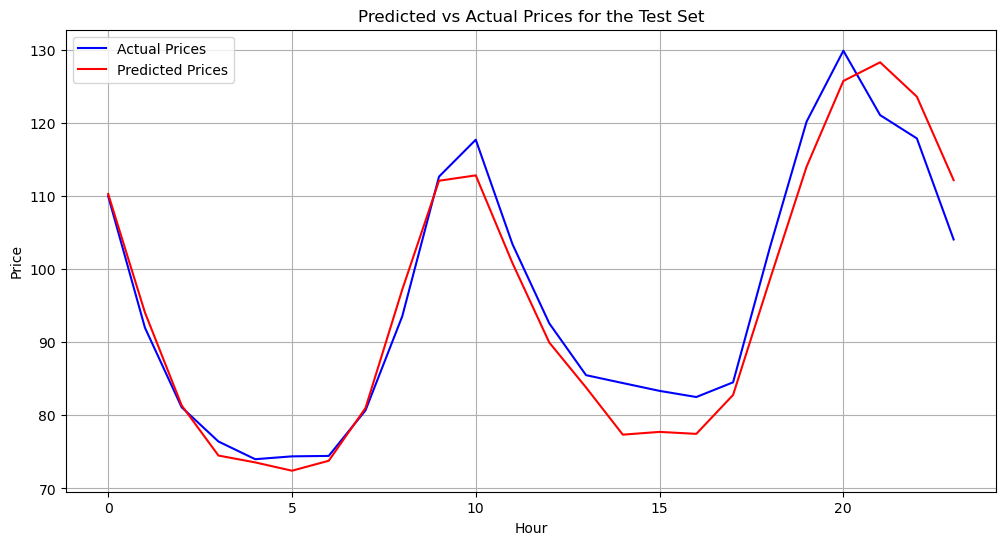

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# File paths
file_path = '../formatted_data/formatted_data.csv'

# Define input and output sequence lengths
sequence_length = 336  # Use 2 weeks of history
output_sequence_length = 24  # Predict the next 24 hours
batch_size = 32
test_split_ratio = 0.1

# Load the data
data = pd.read_csv(file_path)

start_date = "2023-01-01"
end_date = "2024-06-30"

# Convert to datetime for filtering
data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]

# Drop the `Date` column after filtering (if not needed further)
data = data.drop(columns=['Date'])

# Define feature columns (excluding time-based features)
weather_columns = [
    'Price_EUR_MWh', 'Volume_MWh', 'ID',
    'Andalusia (Wind)_temperature', 'Andalusia (Wind)_wind_u_component', 'Andalusia (Wind)_wind_v_component',
    'Aragon (Wind)_temperature', 'Aragon (Wind)_wind_u_component', 'Aragon (Wind)_wind_v_component',
    'Barcelona_temperature', 'Barcelona_wind_u_component', 'Barcelona_wind_v_component',
    'Bilbao_temperature', 'Bilbao_wind_u_component', 'Bilbao_wind_v_component',
    'Castile-La Mancha (Wind)_temperature', 'Castile-La Mancha (Wind)_wind_u_component', 'Castile-La Mancha (Wind)_wind_v_component',
    'Escatrón-Chiprana-Samper (Solar)_temperature', 'Escatrón-Chiprana-Samper (Solar)_wind_u_component', 'Escatrón-Chiprana-Samper (Solar)_wind_v_component',
    'Madrid_temperature', 'Madrid_wind_u_component', 'Madrid_wind_v_component',
    'Seville_temperature', 'Seville_wind_u_component', 'Seville_wind_v_component',
    'Talasol Solar (Solar)_temperature', 'Talasol Solar (Solar)_wind_u_component', 'Talasol Solar (Solar)_wind_v_component',
    'Talayuela Solar (Solar)_temperature', 'Talayuela Solar (Solar)_wind_u_component', 'Talayuela Solar (Solar)_wind_v_component',
    'Valencia_temperature', 'Valencia_wind_u_component', 'Valencia_wind_v_component'
]
time_columns = ['Hour_Sin', 'Hour_Cos', 'Day_Sin', 'Day_Cos', 'Month_Sin', 'Month_Cos']
target_column = 'DA'

data[weather_columns] = data[weather_columns].shift(-24) 

# Drop rows with missing values
data = data.dropna(subset=weather_columns + [target_column])

# Initialize scalers
scaler_weather = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

# Fit scalers on weather features and target column
weather_scaled = scaler_weather.fit_transform(data[weather_columns])
target_scaled = scaler_target.fit_transform(data[[target_column]])

# Concatenate scaled weather and unscaled time features
features_scaled = np.hstack([weather_scaled, data[time_columns].values])

# Prepare data for sequences
X = []
y = []

for i in range(len(features_scaled) - sequence_length - output_sequence_length):
    X.append(features_scaled[i:i + sequence_length])  # Input sequence
    y.append(target_scaled[i + sequence_length:i + sequence_length + output_sequence_length].flatten())  # Target sequence

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Train-test split
split_idx = int(len(X) * (1 - test_split_ratio))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[:, -1, :])
        return output

# Model parameters
hidden_size = 64  # Increased from 50
num_layers = 2     # Increased to 2 layers
dropout = 0.1     # Add dropout to LSTM
learning_rate = 0.001
input_size = X_train.shape[2]
output_size = output_sequence_length

model = LSTMModel(input_size, hidden_size, output_size, num_layers=num_layers, dropout=dropout)


# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 200
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_loader):.6f}")

# Model evaluation and visualization
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test).numpy()

# Rescale predictions and actual values
y_test_pred_rescaled = scaler_target.inverse_transform(y_test_pred)
y_test_actual_rescaled = scaler_target.inverse_transform(y_test)

# Plotting predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test_actual_rescaled[0])), y_test_actual_rescaled[0], label="Actual Prices", color="blue")
plt.plot(range(len(y_test_pred_rescaled[0])), y_test_pred_rescaled[0], label="Predicted Prices", color="red")
plt.title("Predicted vs Actual Prices for the Test Set")
plt.xlabel("Hour")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


### Visualization of Predictions ###
Best Performance (Index: 0) - RMSE: 4.09, MAPE: 3.34%, R-squared: 0.94


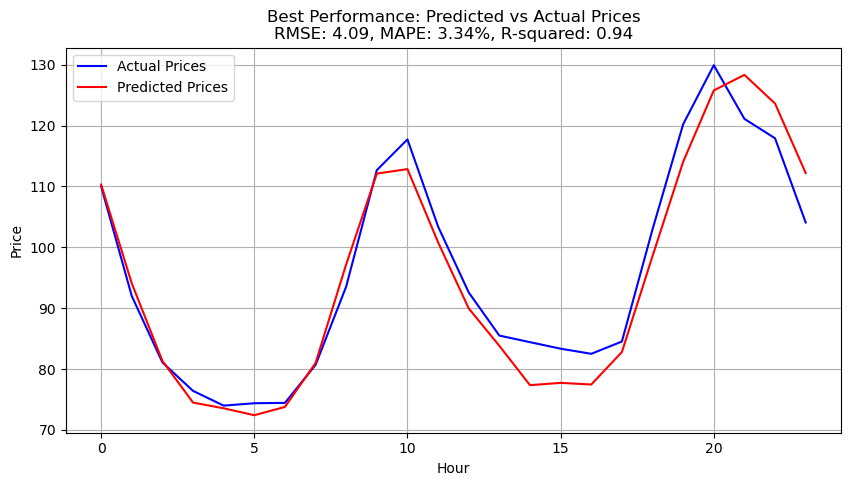

Worst Performance (Index: 185) - RMSE: 75.84, MAPE: 68.56%, R-squared: -7.48


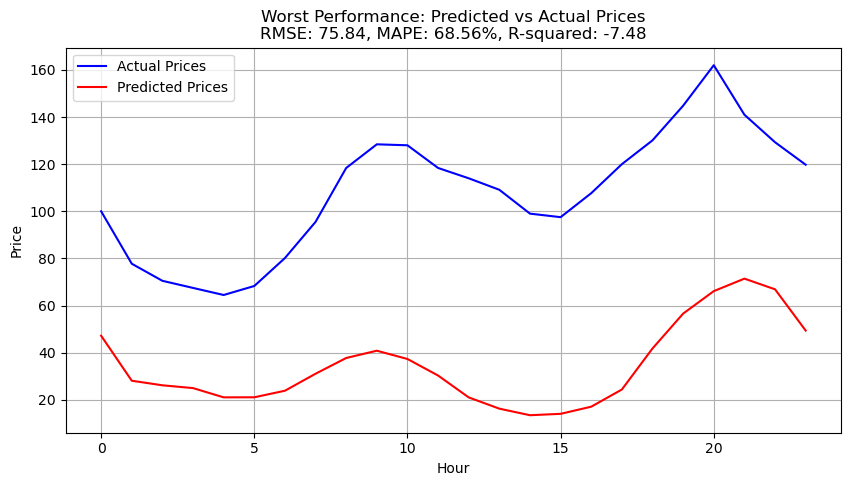

Median Performance (Index: 435) - RMSE: 21.96, MAPE: 21.54%, R-squared: -0.54


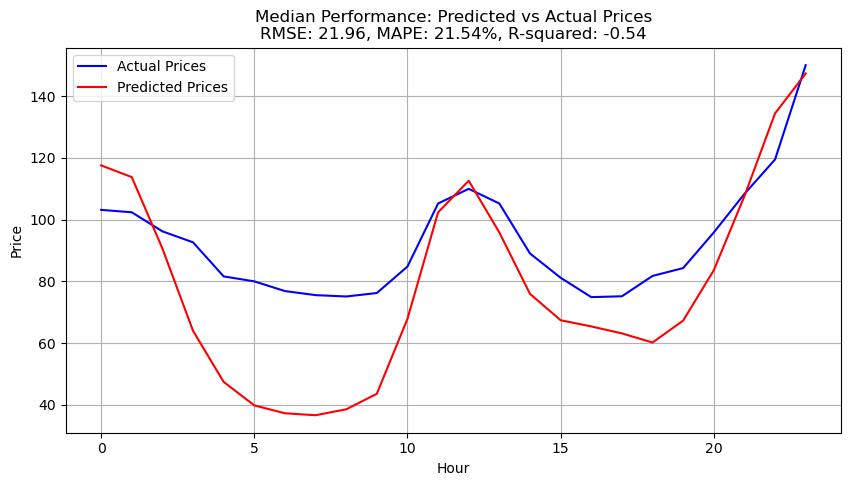


### Metrics Summary ###
Average RMSE: 32.51
Median RMSE: 21.93
Average MAPE: 45.50%
Median MAPE: 29.64%
Average R-squared: -2.50
Median R-squared: -0.52


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import torch

# Predict on test data using PyTorch
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test).numpy()  # Get predictions as numpy array

# Inverse transform predictions and actual values for the target column
y_test_pred_rescaled = scaler_target.inverse_transform(y_test_pred)  # Use the dedicated target scaler
y_test_actual_rescaled = scaler_target.inverse_transform(y_test.numpy())  # Actual values

# Calculate RMSE, MAPE, and R-squared for each sample
rmse_per_sample = []
mape_per_sample = []
r2_per_sample = []

for actual, predicted in zip(y_test_actual_rescaled, y_test_pred_rescaled):
    rmse_per_sample.append(np.sqrt(mean_squared_error(actual, predicted)))
    mape_per_sample.append(np.mean(np.abs((actual - predicted) / actual)) * 100)
    r2_per_sample.append(r2_score(actual, predicted))

# Find indices for best, median, and worst performance based on RMSE
best_index = np.argmin(rmse_per_sample)
worst_index = np.argmax(rmse_per_sample)
median_index = np.argsort(rmse_per_sample)[len(rmse_per_sample) // 2]

# Function to visualize a single prediction vs. actual with metrics
def plot_prediction_with_metrics(index, title):
    actual = y_test_actual_rescaled[index]
    predicted = y_test_pred_rescaled[index]
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    r2 = r2_score(actual, predicted)
    plt.figure(figsize=(10, 5))
    plt.plot(actual, label="Actual Prices", color="blue")
    plt.plot(predicted, label="Predicted Prices", color="red")
    plt.title(f"{title}\nRMSE: {rmse:.2f}, MAPE: {mape:.2f}%, R-squared: {r2:.2f}")
    plt.xlabel("Hour")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize worst, best, and median performances
print("### Visualization of Predictions ###")
print(f"Best Performance (Index: {best_index}) - RMSE: {rmse_per_sample[best_index]:.2f}, "
      f"MAPE: {mape_per_sample[best_index]:.2f}%, R-squared: {r2_per_sample[best_index]:.2f}")
plot_prediction_with_metrics(best_index, "Best Performance: Predicted vs Actual Prices")

print(f"Worst Performance (Index: {worst_index}) - RMSE: {rmse_per_sample[worst_index]:.2f}, "
      f"MAPE: {mape_per_sample[worst_index]:.2f}%, R-squared: {r2_per_sample[worst_index]:.2f}")
plot_prediction_with_metrics(worst_index, "Worst Performance: Predicted vs Actual Prices")

print(f"Median Performance (Index: {median_index}) - RMSE: {rmse_per_sample[median_index]:.2f}, "
      f"MAPE: {mape_per_sample[median_index]:.2f}%, R-squared: {r2_per_sample[median_index]:.2f}")
plot_prediction_with_metrics(median_index, "Median Performance: Predicted vs Actual Prices")

# Summary statistics
print("\n### Metrics Summary ###")
print(f"Average RMSE: {np.mean(rmse_per_sample):.2f}")
print(f"Median RMSE: {np.median(rmse_per_sample):.2f}")
print(f"Average MAPE: {np.mean(mape_per_sample):.2f}%")
print(f"Median MAPE: {np.median(mape_per_sample):.2f}%")
print(f"Average R-squared: {np.mean(r2_per_sample):.2f}")
print(f"Median R-squared: {np.median(r2_per_sample):.2f}")


In [4]:
torch.save(model.state_dict(), "lstm_model.pth")


In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# File paths
file_path = '../formatted_data/formatted_data.csv'

# Define input and output sequence lengths
sequence_length = 336  # Use 2 weeks of history
output_sequence_length = 24  # Predict the next 24 hours
batch_size = 32
test_split_ratio = 0.1

# Load the data
data = pd.read_csv(file_path)

start_date = "2023-01-01"
end_date = "2024-06-30"

# Convert to datetime for filtering
data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]

# Drop the `Date` column after filtering (if not needed further)
data = data.drop(columns=['Date'])

# Define feature columns (excluding time-based features)
weather_columns = [
    'Price_EUR_MWh', 'Volume_MWh', 'DA',
    'Andalusia (Wind)_temperature', 'Andalusia (Wind)_wind_u_component', 'Andalusia (Wind)_wind_v_component',
    'Aragon (Wind)_temperature', 'Aragon (Wind)_wind_u_component', 'Aragon (Wind)_wind_v_component',
    'Barcelona_temperature', 'Barcelona_wind_u_component', 'Barcelona_wind_v_component',
    'Bilbao_temperature', 'Bilbao_wind_u_component', 'Bilbao_wind_v_component',
    'Castile-La Mancha (Wind)_temperature', 'Castile-La Mancha (Wind)_wind_u_component', 'Castile-La Mancha (Wind)_wind_v_component',
    'Escatrón-Chiprana-Samper (Solar)_temperature', 'Escatrón-Chiprana-Samper (Solar)_wind_u_component', 'Escatrón-Chiprana-Samper (Solar)_wind_v_component',
    'Madrid_temperature', 'Madrid_wind_u_component', 'Madrid_wind_v_component',
    'Seville_temperature', 'Seville_wind_u_component', 'Seville_wind_v_component',
    'Talasol Solar (Solar)_temperature', 'Talasol Solar (Solar)_wind_u_component', 'Talasol Solar (Solar)_wind_v_component',
    'Talayuela Solar (Solar)_temperature', 'Talayuela Solar (Solar)_wind_u_component', 'Talayuela Solar (Solar)_wind_v_component',
    'Valencia_temperature', 'Valencia_wind_u_component', 'Valencia_wind_v_component'
]
time_columns = ['Hour_Sin', 'Hour_Cos', 'Day_Sin', 'Day_Cos', 'Month_Sin', 'Month_Cos']
target_column = 'ID'

data[weather_columns] = data[weather_columns].shift(-24) 

# Drop rows with missing values
data = data.dropna(subset=weather_columns + [target_column])

# Initialize scalers
scaler_weather = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

# Fit scalers on weather features and target column
weather_scaled = scaler_weather.fit_transform(data[weather_columns])
target_scaled = scaler_target.fit_transform(data[[target_column]])

# Concatenate scaled weather and unscaled time features
features_scaled = np.hstack([weather_scaled, data[time_columns].values])

# Prepare data for sequences
X = []
y = []

for i in range(len(features_scaled) - sequence_length - output_sequence_length):
    X.append(features_scaled[i:i + sequence_length])  # Input sequence
    y.append(target_scaled[i + sequence_length:i + sequence_length + output_sequence_length].flatten())  # Target sequence

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Train-test split
split_idx = int(len(X) * (1 - test_split_ratio))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[:, -1, :])
        return output

# Model parameters
hidden_size = 64  # Increased from 50
num_layers = 2     # Increased to 2 layers
dropout = 0.1     # Add dropout to LSTM
learning_rate = 0.001
input_size = X_train.shape[2]
output_size = output_sequence_length

model = LSTMModel(input_size, hidden_size, output_size, num_layers=num_layers, dropout=dropout)


# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 200
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_loader):.6f}")

# Model evaluation and visualization
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test).numpy()

# Rescale predictions and actual values
y_test_pred_rescaled = scaler_target.inverse_transform(y_test_pred)
y_test_actual_rescaled = scaler_target.inverse_transform(y_test)

# Plotting predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test_actual_rescaled[0])), y_test_actual_rescaled[0], label="Actual Prices", color="blue")
plt.plot(range(len(y_test_pred_rescaled[0])), y_test_pred_rescaled[0], label="Predicted Prices", color="red")
plt.title("Predicted vs Actual Prices for the Test Set")
plt.xlabel("Hour")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


Training data shape: torch.Size([5182, 336, 42])
Test data shape: torch.Size([576, 336, 42])
Epoch 1/200, Loss: 0.029357
Epoch 2/200, Loss: 0.007082
Epoch 3/200, Loss: 0.005655
Epoch 4/200, Loss: 0.004334
Epoch 5/200, Loss: 0.003599
Epoch 6/200, Loss: 0.003227
Epoch 7/200, Loss: 0.002881
Epoch 8/200, Loss: 0.002469
Epoch 9/200, Loss: 0.002238
Epoch 10/200, Loss: 0.002162
Epoch 11/200, Loss: 0.001990
Epoch 12/200, Loss: 0.001860
Epoch 13/200, Loss: 0.001883
Epoch 14/200, Loss: 0.001698
Epoch 15/200, Loss: 0.001612
Epoch 16/200, Loss: 0.001579
Epoch 17/200, Loss: 0.001464
Epoch 18/200, Loss: 0.001421
Epoch 19/200, Loss: 0.001361
Epoch 20/200, Loss: 0.001312
Epoch 21/200, Loss: 0.001265
Epoch 22/200, Loss: 0.001217
Epoch 23/200, Loss: 0.001201
Epoch 24/200, Loss: 0.001155
Epoch 25/200, Loss: 0.001110
Epoch 26/200, Loss: 0.001068
Epoch 27/200, Loss: 0.001065
Epoch 28/200, Loss: 0.001017
Epoch 29/200, Loss: 0.000992
Epoch 30/200, Loss: 0.000961
Epoch 31/200, Loss: 0.000939
Epoch 32/200, Los

KeyboardInterrupt: 

### Visualization of Predictions ###
Best Performance (Index: 0) - RMSE: 9.70, MAPE: 7.98%, R-squared: 0.77


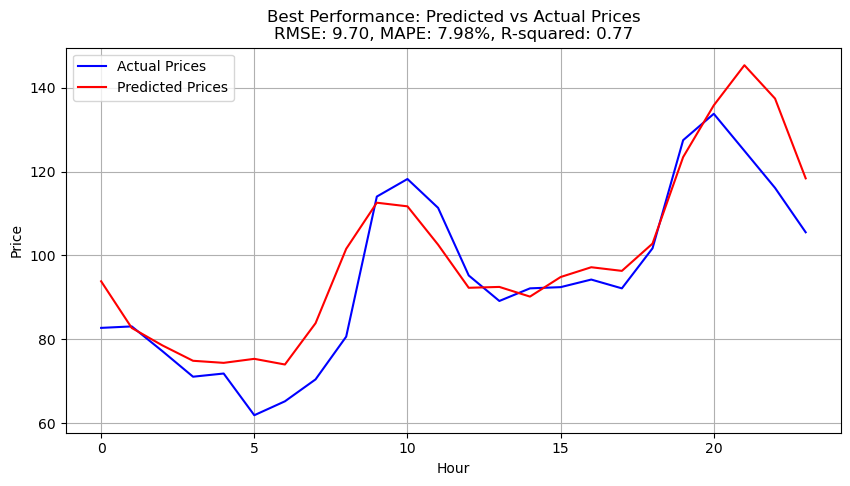

Worst Performance (Index: 226) - RMSE: 59.37, MAPE: 69.03%, R-squared: -5.14


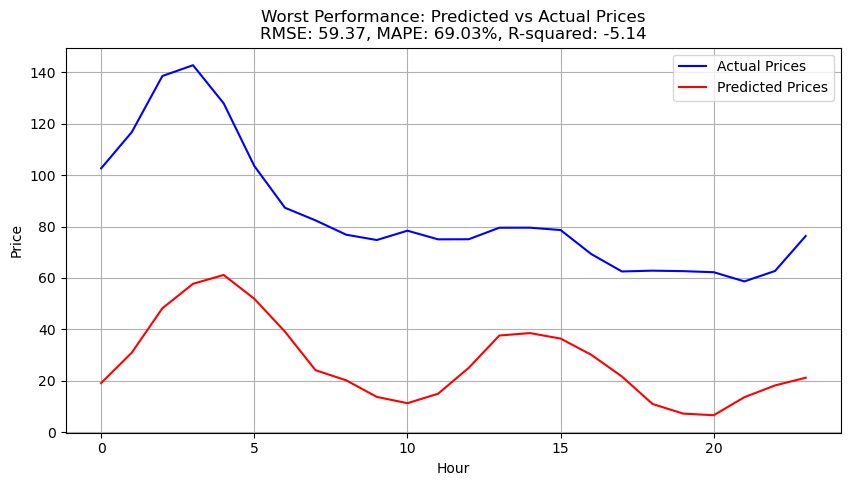

Median Performance (Index: 146) - RMSE: 22.51, MAPE: 19.20%, R-squared: -1.57


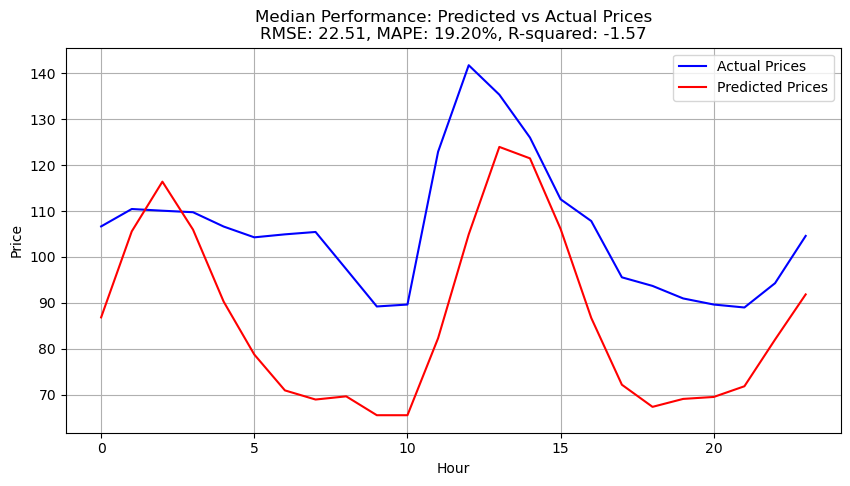


### Metrics Summary ###
Average RMSE: 25.87
Median RMSE: 22.51
Average MAPE: 35.83%
Median MAPE: 26.64%
Average R-squared: -1.56
Median R-squared: -0.29


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import torch

# Predict on test data using PyTorch
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test).numpy()  # Get predictions as numpy array

# Inverse transform predictions and actual values for the target column
y_test_pred_rescaled = scaler_target.inverse_transform(y_test_pred)  # Use the dedicated target scaler
y_test_actual_rescaled = scaler_target.inverse_transform(y_test.numpy())  # Actual values

# Calculate RMSE, MAPE, and R-squared for each sample
rmse_per_sample = []
mape_per_sample = []
r2_per_sample = []

for actual, predicted in zip(y_test_actual_rescaled, y_test_pred_rescaled):
    rmse_per_sample.append(np.sqrt(mean_squared_error(actual, predicted)))
    mape_per_sample.append(np.mean(np.abs((actual - predicted) / actual)) * 100)
    r2_per_sample.append(r2_score(actual, predicted))

# Find indices for best, median, and worst performance based on RMSE
best_index = np.argmin(rmse_per_sample)
worst_index = np.argmax(rmse_per_sample)
median_index = np.argsort(rmse_per_sample)[len(rmse_per_sample) // 2]

# Function to visualize a single prediction vs. actual with metrics
def plot_prediction_with_metrics(index, title):
    actual = y_test_actual_rescaled[index]
    predicted = y_test_pred_rescaled[index]
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    r2 = r2_score(actual, predicted)
    plt.figure(figsize=(10, 5))
    plt.plot(actual, label="Actual Prices", color="blue")
    plt.plot(predicted, label="Predicted Prices", color="red")
    plt.title(f"{title}\nRMSE: {rmse:.2f}, MAPE: {mape:.2f}%, R-squared: {r2:.2f}")
    plt.xlabel("Hour")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize worst, best, and median performances
print("### Visualization of Predictions ###")
print(f"Best Performance (Index: {best_index}) - RMSE: {rmse_per_sample[best_index]:.2f}, "
      f"MAPE: {mape_per_sample[best_index]:.2f}%, R-squared: {r2_per_sample[best_index]:.2f}")
plot_prediction_with_metrics(best_index, "Best Performance: Predicted vs Actual Prices")

print(f"Worst Performance (Index: {worst_index}) - RMSE: {rmse_per_sample[worst_index]:.2f}, "
      f"MAPE: {mape_per_sample[worst_index]:.2f}%, R-squared: {r2_per_sample[worst_index]:.2f}")
plot_prediction_with_metrics(worst_index, "Worst Performance: Predicted vs Actual Prices")

print(f"Median Performance (Index: {median_index}) - RMSE: {rmse_per_sample[median_index]:.2f}, "
      f"MAPE: {mape_per_sample[median_index]:.2f}%, R-squared: {r2_per_sample[median_index]:.2f}")
plot_prediction_with_metrics(median_index, "Median Performance: Predicted vs Actual Prices")

# Summary statistics
print("\n### Metrics Summary ###")
print(f"Average RMSE: {np.mean(rmse_per_sample):.2f}")
print(f"Median RMSE: {np.median(rmse_per_sample):.2f}")
print(f"Average MAPE: {np.mean(mape_per_sample):.2f}%")
print(f"Median MAPE: {np.median(mape_per_sample):.2f}%")
print(f"Average R-squared: {np.mean(r2_per_sample):.2f}")
print(f"Median R-squared: {np.median(r2_per_sample):.2f}")
